# Lab Four: The Multi-Layer Preceptron
##### Authors: Alex Wright, Wali Chaudhary, & Bryce Shurts

In [31]:
# General imports
import pandas as pd
from pandas import (DataFrame, Series)
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from imblearn.over_sampling import SVMSMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler

## Load, Split, and Balance

In [22]:
#1. Load the data into memory and save it to a pandas data frame. Do not normalize or one-hot encode any of the features
df: DataFrame = pd.read_csv("acs2017_census_tract_data.csv")
df.head()

,TractId,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,1001020100,Alabama,Autauga County,1845,899,946,2.4,86.3,5.2,0.0,...,0.5,0.0,2.1,24.5,881,74.2,21.2,4.5,0.0,4.6
1,1001020200,Alabama,Autauga County,2172,1167,1005,1.1,41.6,54.5,0.0,...,0.0,0.5,0.0,22.2,852,75.9,15.0,9.0,0.0,3.4
2,1001020300,Alabama,Autauga County,3385,1533,1852,8.0,61.4,26.5,0.6,...,1.0,0.8,1.5,23.1,1482,73.3,21.1,4.8,0.7,4.7
3,1001020400,Alabama,Autauga County,4267,2001,2266,9.6,80.3,7.1,0.5,...,1.5,2.9,2.1,25.9,1849,75.8,19.7,4.5,0.0,6.1
4,1001020500,Alabama,Autauga County,9965,5054,4911,0.9,77.5,16.4,0.0,...,0.8,0.3,0.7,21.0,4787,71.4,24.1,4.5,0.0,2.3


In [23]:
# 2. Remove any observations that having [sic] missing data
print("Missing entries: " + str(df.isna().sum().sum() > 0) + "; " + str(df.shape[0]) + " samples total.")
if df.isna().sum().sum() > 0:
    print("Removing samples with missing data...")
    df.dropna(inplace=True)
    print("Missing entries: " + str(df.isna().sum().sum() > 0) + "; " + str(df.shape[0]) + " samples total.")

Missing entries: True; 74001 samples total.
Removing samples with missing data...
Missing entries: False; 72718 samples total.


In [28]:
# 3. Encode any string data as integers for now
#print(df.dtypes)
for column in df.select_dtypes(include=object).columns:
    df[column] = df[column].astype("category", copy=False).cat.codes
df.head()
# Not really sure what we're being asked to do here, since we're told to not one-hot encode until later... label encoding I guess?

,TractId,State,County,TotalPop,Men,Women,Hispanic,White,Black,Native,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,1001020100,0,89,1845,899,946,2.4,86.3,5.2,0.0,...,0.5,0.0,2.1,24.5,881,74.2,21.2,4.5,0.0,4.6
1,1001020200,0,89,2172,1167,1005,1.1,41.6,54.5,0.0,...,0.0,0.5,0.0,22.2,852,75.9,15.0,9.0,0.0,3.4
2,1001020300,0,89,3385,1533,1852,8.0,61.4,26.5,0.6,...,1.0,0.8,1.5,23.1,1482,73.3,21.1,4.8,0.7,4.7
3,1001020400,0,89,4267,2001,2266,9.6,80.3,7.1,0.5,...,1.5,2.9,2.1,25.9,1849,75.8,19.7,4.5,0.0,6.1
4,1001020500,0,89,9965,5054,4911,0.9,77.5,16.4,0.0,...,0.8,0.3,0.7,21.0,4787,71.4,24.1,4.5,0.0,2.3


In [6]:
# 4. You have the option of keeping the "county" variable or removing it. Be sure to discuss why you decided to keep/remove this variable.

We will keep the county variable, since our goal is to predict the child poverty rate depending on the county. If we don't have the county information, then we will have a more difficult time establishing the relationship between child poverty and county based on the rest of the statistics during the learning process. I.e., if we remove the county then upon passing it into the input layer of the MLP it will not have formed as strong of a relationship between the county and the rest of the features. That, and we also need the feature to exist for when balancing (since we want an even number of instances for each county) and creating the test set.

1045    2300
420     1317
1300     929
1089     885
1189     822
        ... 
232        1
1136       1
1264       1
1112       1
1572       1
Name: County, Length: 1954, dtype: int64


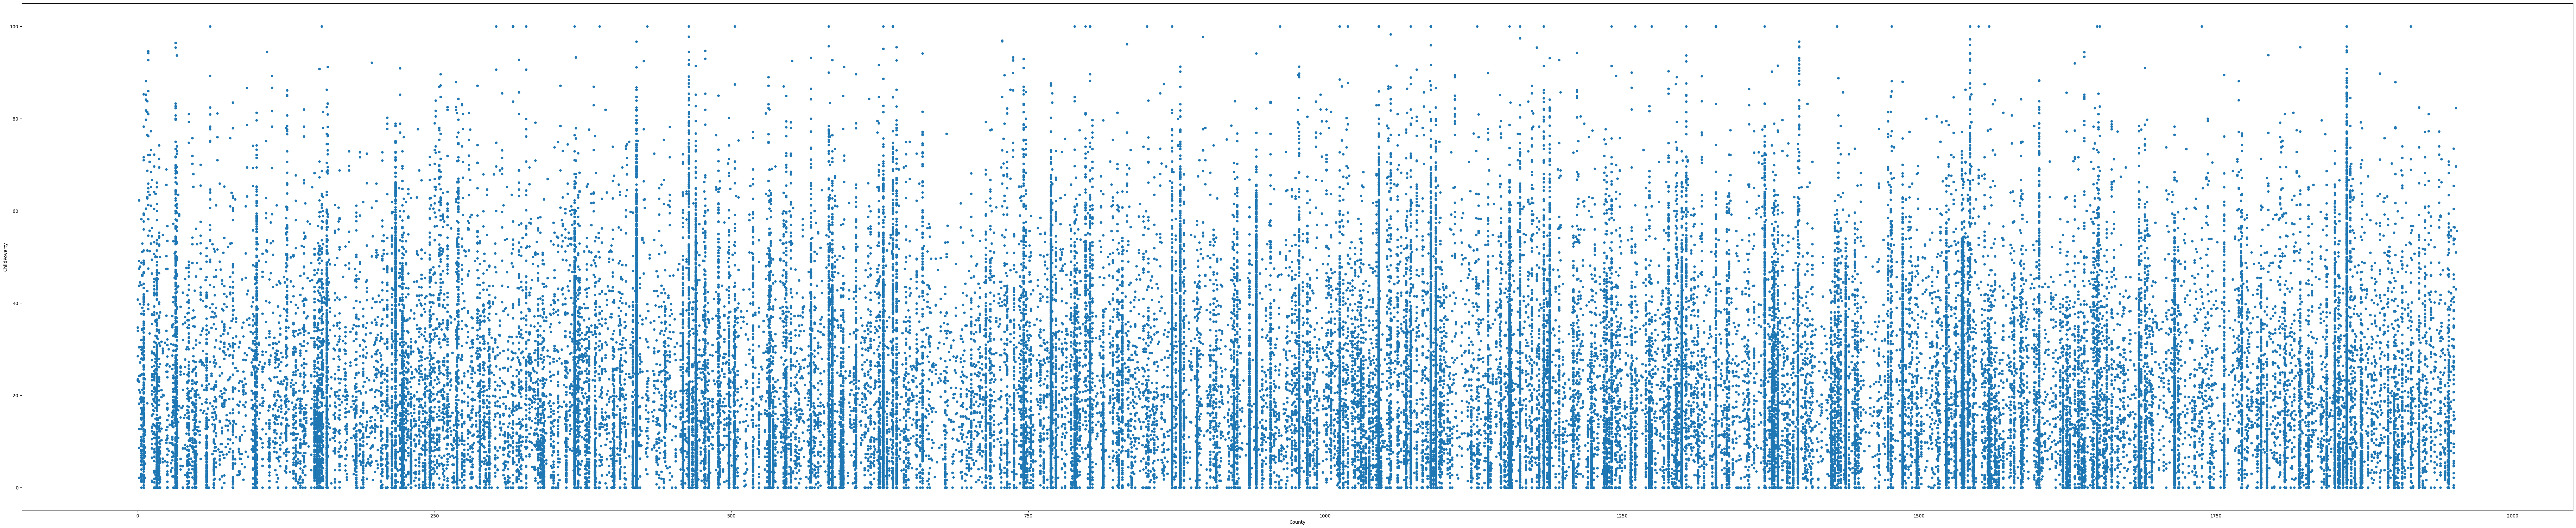

In [29]:
# [.5 points] Balance the dataset so that about the same number of instances are within each class. Choose a method for balancing the dataset and explain your reasoning for selecting this method. Should balancing of the dataset be done for both the training and testing set? Explain.
print(df["County"].value_counts())
df.plot.scatter(x="County", y="ChildPoverty", figsize=(100,20))
plt.show()

One might normally be tempted to undersample to the county with the lowest number of samples, but random undersampling is notorious for creating a poor distribution of data that means the resulting class unrepresentative (i.e., our trained MLP will generalize poorly). Additionally, in our case some counties only have a handful of (or even fewer) samples. Random oversampling does not carry the information loss implications, but might all the same result in us overfitting on the less represented classes, since many of them would need to be sampled many, many times over (as much as 2300x!). So instead, we elect to use interpolation to generate new samples in our under-represented classes via SMOTE, specifically SVMSMOTE to help SMOTE properly identification classification boundaries given the line-esque scattering of county and child poverty rates.

In [30]:
smote = SVMSMOTE(random_state=42)
df_balanced, _ = smote.fit_resample(df, df["County"])
print(df_balanced["County"].value_counts())

df_target: DataFrame = df_balanced["ChildPoverty"]
df_balanced.drop("ChildPoverty", axis=1, inplace=True)

ValueError: Expected n_neighbors <= n_samples,  but n_samples = 4, n_neighbors = 6

In [ ]:
# [.5 points] Assume you are equally interested in the classification performance for each class in the dataset. Split the dataset into 80% for training and 20% for testing.
x_train, x_target, y_train, y_target = train_test_split(df_balanced, df_target, train_size=0.8, test_size=0.2, stratify=df_balanced["County"])
print(x_train.head())
print(x_train["County"].value_counts())
print("---")
print(y_train.head())
print(y_train["County"].value_counts())

## Preprocessing and Initial Modeling

In [ ]:
# [.5 points] Use the example two-layer perceptron network from the class example and quantify performance using accuracy. Do not normalize or one-hot encode the data (not yet). Be sure that training converges by graphing the loss function versus the number of epochs.
# TODO: Refactor this messy & non-PEP 8 code...
class TwoLayerPerceptron(object):
    def __init__(self, n_hidden=30,
                 C=0.0, epochs=500, eta=0.001, random_state=None):
        np.random.seed(random_state)
        self.n_hidden = n_hidden
        self.l2_C = C
        self.epochs = epochs
        self.eta = eta

    def _initialize_weights(self):
        """Initialize weights with small random numbers."""
        W1_num_elems = (self.n_features_ + 1)*self.n_hidden
        W1 = np.random.uniform(-1.0, 1.0, size=W1_num_elems)
        W1 = W1.reshape(self.n_hidden, self.n_features_ + 1) # reshape to be W

        W2_num_elems = (self.n_hidden + 1)*self.n_output_
        W2 = np.random.uniform(-1.0, 1.0, size=W2_num_elems)
        W2 = W2.reshape(self.n_output_, self.n_hidden + 1)
        return W1, W2

    @staticmethod
    def _relu(z):
        # ∀x∈θ max(0, x)
        return np.maximum(0, z)

    @staticmethod
    def _add_bias_unit(X, how='column'):
        """Add bias unit (column or row of 1s) to array at index 0"""
        if how == 'column':
            ones = np.ones((X.shape[0], 1))
            X_new = np.hstack((ones, X))
        elif how == 'row':
            ones = np.ones((1, X.shape[1]))
            X_new = np.vstack((ones, X))
        else:
            raise RuntimeError("Invalid 'how' selection for bias addition")
        return X_new

    def _feedforward(self, X, W1, W2):
        """Compute feedforward step
        -----------
        X : Input layer with original features.
        W1: Weight matrix for input layer -> hidden layer.
        W2: Weight matrix for hidden layer -> output layer.
        ----------
        a1-a3 : activations into layer (or output layer)
        z1-z2 : layer inputs

        """
        A1 = self._add_bias_unit(X.T, how='row')
        Z1 = W1 @ A1
        A2 = self._relu(Z1)

        A2 = self._add_bias_unit(A2, how='row')
        Z2 = W2 @ A2
        A3 = self._relu(Z2)
        return A1, Z1, A2, Z2, A3

    def fit(self, X, y):
        """ Learn weights from training data.
            Input X should be a matrix with separate instances
            in each row, and separate features in each column.
            The target variable, y, should be integer values
            starting from zero, that represent the unique classes.
        """

        # copy over the data and one-hot-encode Y
        X_data, y_data = X.copy(), y.copy()

        # init weights and setup matrices
        self.n_features_ = X_data.shape[1]
        self.n_output_ = y_data.shape[0]
        self.W1, self.W2 = self._initialize_weights()

        self.grad_w1_ = np.zeros(self.epochs)
        self.grad_w2_ = np.zeros(self.epochs)

        # run training for specified number of iterations
        for i in range(self.epochs):

            # feedforward all instances
            A1, Z1, A2, Z2, A3 = self._feedforward(X_data,self.W1,self.W2)

            # compute gradient via backpropagation
            grad1, grad2 = self._get_gradient(A1=A1, A2=A2, A3=A3, Z1=Z1, Z2=Z2, Y=Y_enc,
                                              W1=self.W1, W2=self.W2)

            self.grad_w1_[i] = np.mean(np.abs(grad1))
            self.grad_w2_[i] = np.mean(np.abs(grad2))

            # update each matrix to minimize objective function
            self.W1 -= self.eta * grad1
            self.W2 -= self.eta * grad2

        return self

    def _get_gradient(self, A1, A2, A3, Z1, Z2, Y, W1, W2):
        """ Compute gradient step using backpropagation."""
        V2 = -2.0 * (Y - A3) * A3 * (1 - A3)
        V1 = A2 * (1 - A2) * (W2.T @ V2)

        grad2 = V2 @ A2.T
        grad1 = V1[1:,:] @ A1.T # don't include added bias term in recurrence relation

        return grad1, grad2

    def predict(self, X):
        """Predict class labels"""
        _, _, _, _, A3 = self._feedforward(X, self.W1, self.W2)
        y_pred = np.argmax(A3, axis=0)
        return y_pred



In [ ]:
clf = TwoLayerPerceptron(n_hidden=10, epochs=1500, eta=0.001)
clf.fit(x_train, x_target)
y_hat = clf.predict(x_train)
print(accuracy_score(x_target, y_hat))
plt.subplot(1,1,1)
plt.plot(abs(clf.grad_w1_[10:]), label='w1')
plt.plot(abs(clf.grad_w2_[10:]), label='w2')
plt.legend()
plt.ylabel('Average gradient magnitude')
plt.xlabel('Iteration')
plt.show()

In [ ]:
# [.5 points] Now (1) normalize the continuous numeric feature data. Use the example two-layer perceptron network from the class example and quantify performance using accuracy. Be sure that training converges by graphing the loss function versus the number of epoch
x_train = pd.DataFrame(MinMaxScaler().fit_transform(x_train), columns=x_train.columns)

clf = TwoLayerPerceptron(n_hidden=10, epochs=1500, eta=0.001)
clf.fit(x_train, x_target)
y_hat = clf.predict(x_train)
print(accuracy_score(x_target, y_hat))
plt.subplot(1,1,1)
plt.plot(abs(clf.grad_w1_[10:]), label='w1')
plt.plot(abs(clf.grad_w2_[10:]), label='w2')
plt.legend()
plt.ylabel('Average gradient magnitude')
plt.xlabel('Iteration')
plt.show()

In [ ]:
# [.5 points] Now(1) normalize the continuous numeric feature data AND (2) one hot encode the categorical data. Use the example two-layer perceptron network from the class example and quantify performance using accuracy. Be sure that training converges by graphing the loss function versus the number of epochs.
x_train = pd.get_dummies(x_train[["State", "County"]])
x_train.drop(["State", "County"], axis=1, inplace=True)

clf = TwoLayerPerceptron(n_hidden=10, epochs=1500, eta=0.001)
clf.fit(x_train, x_target)
y_hat = clf.predict(x_train)
print(accuracy_score(x_target, y_hat))
plt.subplot(1,1,1)
plt.plot(abs(clf.grad_w1_[10:]), label='w1')
plt.plot(abs(clf.grad_w2_[10:]), label='w2')
plt.legend()
plt.ylabel('Average gradient magnitude')
plt.xlabel('Iteration')
plt.show()

"[1 points] Compare the performance of the three models you just trained. Are there any meaningful differences in performance? Explain, in your own words, why these models have (or do not have) different performances. "

Need to figure out a better way to get SMOTE to work (or some other strategy for balancing that isn't strictly over/undersampling. Then we can run the numbers & do some comparisons.

## Modeling